In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from MCEVAE import *
from utils import *

In [2]:
start_index = 600
nimages = 40
dtype = 'test' 
transformation = 'se2'
mnist_SE2 = torch.from_numpy(np.load('mnist_' + transformation + '_' + dtype +'.npy'))[:10000]
mnist_SE2_init = torch.from_numpy(np.load('mnist_init_' + transformation + '_' + dtype + '.npy'))[:10000]
mnist_SE2_target = torch.from_numpy(np.load('mnist_target_' + transformation + '_' + dtype + '.npy'))[:10000]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
tag = 'default'
model = MCEVAE(in_size=28*28,
                     aug_dim=16*7*7,
                     latent_z_c=10,
                     latent_z_var=3,
                     mode='SE2', 
                     invariance_decoder='gated', 
                     rec_loss='bce', 
                     div='KL',
                     in_dim=1, 
                     out_dim=1, 
                     hidden_z_c=512,
                     hidden_z_var=512,
                     hidden_tau=32, 
                     activation=nn.Sigmoid,
                     training_mode = 'unsupervised',
                     device = device,
                     tag = tag).to(device)

lr = 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)
modelname = "model_{}_{}_dEnt_{}_ddisEnt_{}_{}_{}_{}_checkpoint".format(model.mode, 
                                                                            model.invariance_decoder,
                                                                            model.latent_z_c,
                                                                            model.latent_z_var,
                                                                            model.tag,
                                                                            model.training_mode,
                                                                            model.rec_loss)
model, optim, epoch = load_checkpoint(model, optim, 'models/' + modelname)
model = model.to(device)

in_size: 784, latent_z_ent: 10, latent_z_disent:3, mode: SE2, sem_dec: gated, rec_loss: bce, div: KL
=> loading checkpoint 'models/model_SE2_gated_dEnt_10_ddisEnt_3_default_unsupervised_bce_checkpoint'
=> loaded checkpoint 'models/model_SE2_gated_dEnt_10_ddisEnt_3_default_unsupervised_bce_checkpoint' (epoch 56)


In [4]:
with torch.no_grad():
    x = mnist_SE2.to(device)
    x_init = mnist_SE2_init.to(device)    
    x_hat, z_var_q, z_var_q_mu, z_var_q_logvar, \
    z_c_q, z_c_q_mu, z_c_q_logvar, z_c_q_L, \
    tau_q, tau_q_mu, tau_q_logvar, x_rec, M = model(x)

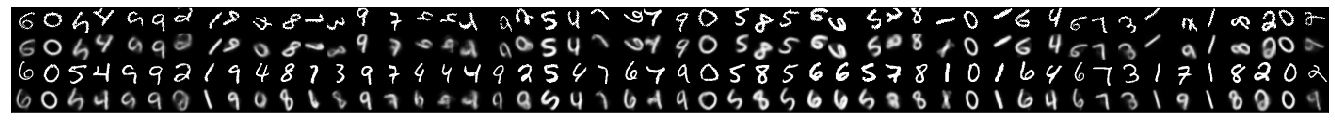

In [5]:
x = x.cpu()
x_hat = x_hat.cpu()
x_rec = x_rec.cpu()
x_init = x_init.cpu()

def plotter(nrow, ncol, subplot_index, dataset, start_index = 100, nimages= 50):
    plt.subplot(nrow,ncol, subplot_index)
    images = dataset[start_index].reshape((28,-1))
    for i in range(start_index+1,start_index+nimages):
        images = np.append(images, dataset[i].reshape((28,-1)), 1)
    plt.tight_layout()
    plt.imshow(images, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)


fig = plt.figure(figsize=(nimages*0.5,2))
plotter(4,1,1, x)
plotter(4,1,2, x_hat)
plotter(4,1,3, x_init)
plotter(4,1,4, x_rec)
plt.savefig("images/" + modelname.replace("_checkpoint",".png"))

In [7]:
image_map_x = {}
image_map_x_hat = {}
image_map_x_init = {}
image_map_x_rec = {}
for i in range(10):
    image_map_x[i] = []
    image_map_x_hat[i] = []
    image_map_x_init[i] = []
    image_map_x_rec[i] = []

x = torch.clamp(x, 1.e-5, 1-1.e-5)
x_init = torch.clamp(x_init, 1.e-5, 1-1.e-5)
x_hat = torch.clamp(x_hat, 1.e-5, 1-1.e-5)
x_rec = torch.clamp(x_rec, 1.e-5, 1-1.e-5)
y = mnist_SE2_target
rec_loss = torch.sum(-(x * torch.log(x_hat) + (1-x)*torch.log(1-x_hat)), dim=(1,2,3))

In [8]:
for ii in range(10):
    #target = y[ii].item
    all_x = x[y == ii]
    all_x_hat = x_hat[y == ii]
    all_x_rec = x_rec[y == ii]
    all_x_init = x_init[y == ii]
    losses = rec_loss[y == ii]
    _minsum = torch.min(torch.sum(all_x, (1,2,3))).item()
    _maxsum = torch.max(torch.sum(all_x, (1,2,3))).item()
    _minloss = torch.min(losses).item()
    for jj in range(all_x.shape[0]):
        this_sum = torch.sum(all_x[jj]).item()
        if this_sum > (_minsum + _maxsum)/4.0 and len(image_map_x[ii]) < 4 and losses[jj] < 1.5*_minloss:
            print("adding image for ", ii)
            image_map_x[ii].append(all_x[jj])
            image_map_x_hat[ii].append(all_x_hat[jj])
            image_map_x_rec[ii].append(all_x_rec[jj])
            image_map_x_init[ii].append(all_x_init[jj])
        

adding image for  0
adding image for  0
adding image for  0
adding image for  0
adding image for  1
adding image for  1
adding image for  1
adding image for  1
adding image for  2
adding image for  2
adding image for  2
adding image for  2
adding image for  3
adding image for  3
adding image for  3
adding image for  3
adding image for  4
adding image for  4
adding image for  4
adding image for  4
adding image for  5
adding image for  5
adding image for  5
adding image for  5
adding image for  6
adding image for  6
adding image for  6
adding image for  6
adding image for  7
adding image for  7
adding image for  7
adding image for  7
adding image for  8
adding image for  8
adding image for  8
adding image for  8
adding image for  9
adding image for  9
adding image for  9
adding image for  9


In [9]:
def recoSampler(keys = range(10)):
    im_x = []
    im_x_hat = []
    im_x_rec = []
    im_x_init = []
    for jj in keys:
        im_x = im_x + image_map_x[jj]
        im_x_hat = im_x_hat + image_map_x_hat[jj]
        im_x_rec = im_x_rec + image_map_x_rec[jj]
        im_x_init = im_x_init + image_map_x_init[jj]

    fig = plt.figure(figsize=(int(len(im_x)/2),2))
    plotter(4,1,1, im_x, 0, int(len(im_x)))
    plotter(4,1,2, im_x_hat, 0, int(len(im_x)))
    plotter(4,1,3, im_x_init, 0, int(len(im_x)))
    plotter(4,1,4, im_x_rec, 0, int(len(im_x)))

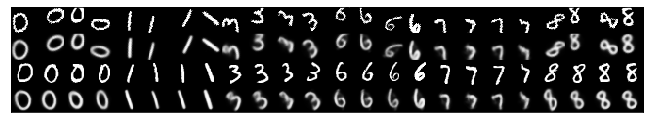

In [10]:
recoSampler([0,1,3,6,7,8])
plt.savefig("images/" + modelname.replace("_checkpoint", "_sample.png"))

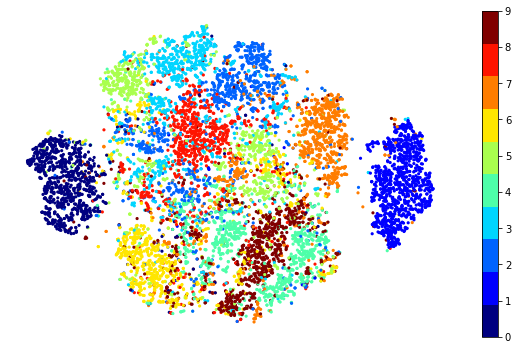

In [12]:
from sklearn.manifold import TSNE
if z_c_q.shape[0] > 0:
    tsne_features = TSNE(n_components=2).fit_transform(z_c_q.cpu().numpy())

    fig = plt.figure(figsize=(10, 6))

    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y[:tsne_features.shape[0]], marker='o',
                edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.grid(False)
    plt.axis('off')
    plt.colorbar()
    plt.savefig("images/" + modelname.replace("_checkpoint", "_clustermap.png"))

In [ ]:
if z_var_q.shape[0] > 0:
    tsne_features = TSNE(n_components=2).fit_transform(z_var_q.cpu().numpy())

    fig = plt.figure(figsize=(10, 6))

    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y[:tsne_features.shape[0]], marker='o',
                edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.grid(False)
    plt.axis('off')
    plt.colorbar()
    plt.savefig("images/" + modelname.replace("_checkpoint", "_clustermap_var.png"))